In [1]:
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Input, Flatten, Conv2D, BatchNormalization, Activation, Dropout, MaxPooling2D, Layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf


In [2]:

data = np.load('/content/flatland_train.npz')
X = data['X']
y = data['y']

y[y != 0] -= 2    # Correct labels so that triangle is mapped to class 1
X = X / 255.      # Scale down to range [0, 1]

# Construct and train your model (don't forget train/test split and other tricks)
# model = ...

In [3]:
def plot(X):
    plt.imshow(X, cmap='gray', vmin=0, vmax=1)
    plt.axis('off')

def apply_filter(X, F):
    x, y = X.shape
    filter_x, filter_y = F.shape
    X_with_filter = np.zeros(shape=(x - filter_x, y - filter_y))

    for i in range(x - filter_x):
        for j in range(y - filter_y):
            X_with_filter[i, j] = (X[i:(i+filter_x), j:(j+filter_y)] * F).sum()

    return X_with_filter

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
         X, y,
         test_size = 0.2, random_state = 42
)

In [5]:
def add_black_pixels(img): #previous idea, didn't use it

    color = np.minimum(np.min(img[:, 0]), np.min(img[0, :]))

    # Get the dimensions of the original image
    height, width = img.shape[:2]

    # Define the amount of padding
    padding_size = 2

    # Create a new image with increased dimensions
    new_height = height + 2 * padding_size
    new_width = width + 2 * padding_size

    # Create a black canvas with increased dimensions
    new_img = tf.Tensor((new_height, new_width, 1), color, dtype=float64)

    # Place the original image at an offset to add black pixels
    new_img[padding_size:new_height-padding_size, padding_size:new_width-padding_size] = img

    return new_img

In [6]:
X_train = X_train.reshape(X_train.shape[0], 50, 50, 1)
X_test = X_test.reshape(X_test.shape[0], 50, 50, 1)

In [7]:
img = X_train[12]

color = np.minimum(np.min(img[:, 0]), np.min(img[0, :]))

color

0.0

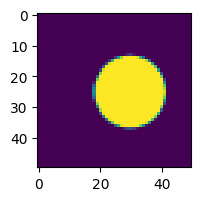

In [8]:
plt.figure(figsize=(2, 2))
plt.imshow(X_train[3])

In [9]:
from PIL import Image
import cv2

In [10]:
def corners(img): #previous idea, didn't use it

    # Convert the image to float32
    img = np.float32(img)

    # Apply Harris corner detection
    harris_corners = cv2.cornerHarris(img, blockSize=2, ksize=3, k=0.04)

    # Dilate the corners to make them visible
    harris_corners = cv2.dilate(harris_corners, None)

    # Threshold for an optimal value, it may vary depending on the image
    threshold = 0.01 * harris_corners.max()

    # Create an image copy to mark the corners
    marked_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    marked_img[harris_corners > threshold] = [0, 0, 255]  # Mark corners in red

    return marked_img

In [11]:
img = np.float32(X_train[5])
img.shape

(50, 50, 1)

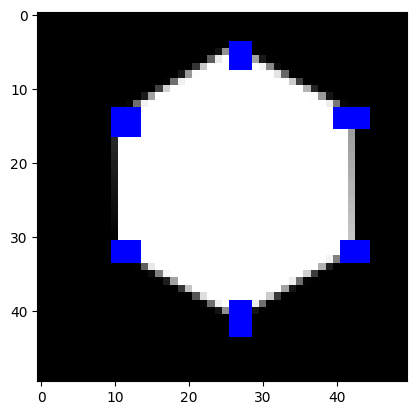

In [12]:
plt.imshow(corners(X_train[6]))

In [13]:
def update_pixels(image): #previous idea, didn't use it
    # Threshold the image: set pixels > 0.1 to 1
    threshold_value = 0.1
    thresholded_image = np.where(image > threshold_value, 1, 0)

    return thresholded_image

In [14]:
def unblur_edge(image): #previous idea, didn't use it
    img = np.uint8(image)

    # Apply Gaussian blur to the whole image (for demonstration)
    blurred = cv2.GaussianBlur(img, (15, 15), 0)

    # Perform edge detection using Canny edge detector
    edges = cv2.Canny(blurred, 30, 150)

    # Dilate the edges to make them more visible
    kernel = np.ones((3, 3), np.uint8)
    dilated_edges = cv2.dilate(edges, kernel, iterations=1)

    # Invert the edges to use as a mask
    mask = cv2.bitwise_not(dilated_edges)

    # Apply deblurring to the edges only
    deblurred_edges = cv2.deconvolve(blurred, np.ones((15, 15), np.float32))

    # Combine the deblurred edges with the original image using the mask
    result = cv2.bitwise_and(image, image, mask=mask)
    result += cv2.bitwise_and(deblurred_edges[1], deblurred_edges[1], mask=dilated_edges)

    return result

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [16]:
datagen = ImageDataGenerator(rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2
)

In [17]:
generator = datagen.flow(
    X_train,
    y_train,
    batch_size = 256)  #images to generate in a batch

In [18]:
model = Sequential()
model.add(Conv2D(10, kernel_size = (5, 5), input_shape = [50, 50, 1]))
model.add(MaxPooling2D())
model.add(Dropout(0.1))
model.add(Conv2D(10, kernel_size = (4, 4)))
model.add(MaxPooling2D())
model.add(Dropout(0.1))
model.add(Conv2D(10, kernel_size = (3, 3)))
model.add(MaxPooling2D())
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(64, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(5, activation = 'softmax'))
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = Adam(learning_rate = 3e-4),
              metrics = ['accuracy']) # maybe SparseCategoricalAccuracy()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 10)        260       
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 10)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 23, 23, 10)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 20, 10)        1610      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 10)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 10, 10, 10)        0

In [19]:
loss = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2)

Epoch 1/50
100/100 [==============================] - 19s 36ms/step - loss: 1.5056 - accuracy: 0.3780 - val_loss: 1.3162 - val_accuracy: 0.4775
Epoch 2/50
100/100 [==============================] - 1s 9ms/step - loss: 1.2355 - accuracy: 0.4747 - val_loss: 1.2122 - val_accuracy: 0.4806
Epoch 3/50
100/100 [==============================] - 1s 6ms/step - loss: 1.1682 - accuracy: 0.4978 - val_loss: 1.1988 - val_accuracy: 0.4875
Epoch 4/50
100/100 [==============================] - 1s 6ms/step - loss: 1.1371 - accuracy: 0.5092 - val_loss: 1.1807 - val_accuracy: 0.5013
Epoch 5/50
100/100 [==============================] - 1s 5ms/step - loss: 1.1146 - accuracy: 0.5166 - val_loss: 1.1440 - val_accuracy: 0.5131
Epoch 6/50
100/100 [==============================] - 1s 6ms/step - loss: 1.0847 - accuracy: 0.5353 - val_loss: 1.1233 - val_accuracy: 0.5163
Epoch 7/50
100/100 [==============================] - 1s 6ms/step - loss: 1.0702 - accuracy: 0.5423 - val_loss: 1.0920 - val_accuracy: 0.5356
Epoc

In [29]:
pred = model.predict(X_test).argmax(axis=1)
print('Accuracy on test set - {0:.02%}'.format((pred == y_test).mean()))

63/63 [==============================] - 0s 2ms/step
Accuracy on test set - 98.00%


In [28]:
loss = model.fit(generator, epochs=100, batch_size=256)

Epoch 1/100
32/32 [==============================] - 3s 95ms/step - loss: 0.3490 - accuracy: 0.8914
Epoch 2/100
32/32 [==============================] - 3s 96ms/step - loss: 0.3477 - accuracy: 0.8930
Epoch 3/100
32/32 [==============================] - 4s 127ms/step - loss: 0.3462 - accuracy: 0.8984
Epoch 4/100
32/32 [==============================] - 3s 96ms/step - loss: 0.3468 - accuracy: 0.8949
Epoch 5/100
32/32 [==============================] - 3s 96ms/step - loss: 0.3513 - accuracy: 0.8942
Epoch 6/100
32/32 [==============================] - 3s 94ms/step - loss: 0.3326 - accuracy: 0.8994
Epoch 7/100
32/32 [==============================] - 3s 93ms/step - loss: 0.3433 - accuracy: 0.8975
Epoch 8/100
32/32 [==============================] - 4s 109ms/step - loss: 0.3376 - accuracy: 0.8995
Epoch 9/100
32/32 [==============================] - 3s 96ms/step - loss: 0.3350 - accuracy: 0.9010
Epoch 10/100
32/32 [==============================] - 3s 104ms/step - loss: 0.3361 - accuracy: 0.9

In [30]:
model.save('model.h5')